In [1]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import rioxarray
from shapely.geometry import mapping
import cftime
from datetime import datetime
import seaborn as sns


# Load data 

In [2]:
filepath=r"C:\Users\Admin\Documents\SpaceSense\geospatial_test_datacube.nc"
dataset=rioxarray.open_rasterio(filepath)

In [3]:
print(dataset)

<xarray.Dataset>
Dimensions:      (time: 23, x: 304, y: 227)
Coordinates:
  * time         (time) object 2021-04-09 00:00:00 ... 2021-11-25 00:00:00
  * x            (x) float64 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
  * y            (y) float64 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 ...
    S2_GREEN     (time, y, x) float32 ...
    S2_BLUE      (time, y, x) float32 ...
    S2_NIR       (time, y, x) float32 ...
Attributes:
    AREA_OR_POINT:    Area
    crs:              +init=epsg:4326
    descriptions:     {RED,GREEN,BLUE,NIR}
    res:              [8.98405270e-05 9.04387077e-05]
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    ulx, uly:         [-69.94990454  45.23320715]
    _FillValue:       nan


Select the last image and extract the red, green, blue bands

In [4]:
Image1=dataset.isel(time=-1)
R=Image1['S2_RED'].values
G=Image1['S2_GREEN'].values
B=Image1['S2_BLUE'].values

stack the bands into an array the plot the image

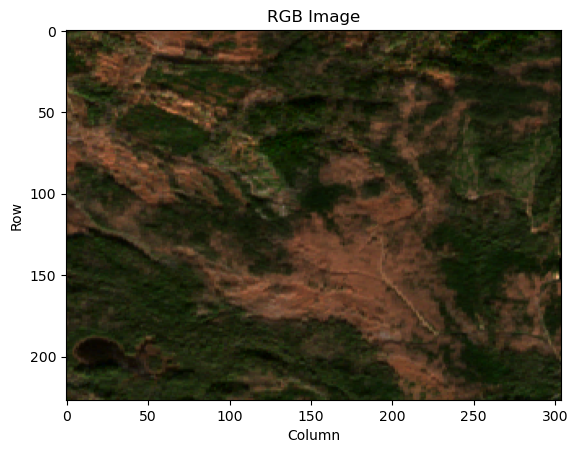

In [5]:
RGBImage = np.dstack((R,G,B))

#Improve image brightness using a linear scaling factor
RGBImage = (RGBImage - np.min(RGBImage)) / (np.max(RGBImage) - np.min(RGBImage))

plt.imshow(RGBImage)


plt.title("RGB Image")
plt.xlabel("Column")
plt.ylabel("Row")

plt.show()


In [6]:
dataset.crs

'+init=epsg:4326'

Select only the Red and NIR bands

In [7]:
dataset = dataset[['S2_RED','S2_NIR']]
print(dataset)

<xarray.Dataset>
Dimensions:      (time: 23, y: 227, x: 304)
Coordinates:
  * time         (time) object 2021-04-09 00:00:00 ... 2021-11-25 00:00:00
  * x            (x) float64 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
  * y            (y) float64 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 ...
    S2_NIR       (time, y, x) float32 ...
Attributes:
    AREA_OR_POINT:    Area
    crs:              +init=epsg:4326
    descriptions:     {RED,GREEN,BLUE,NIR}
    res:              [8.98405270e-05 9.04387077e-05]
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    ulx, uly:         [-69.94990454  45.23320715]
    _FillValue:       nan


In [8]:
aoipath=r"C:\Users\Admin\Documents\SpaceSense\geospatial_sub_aoi.geojson"
aoi=gpd.read_file(aoipath)

In [9]:
aoi.head()

geometry
0  POLYGON ((-69.94867 45.23227, -69.94900 45.217...

In [10]:
print(aoi.crs)

EPSG:4326


<Axes: >

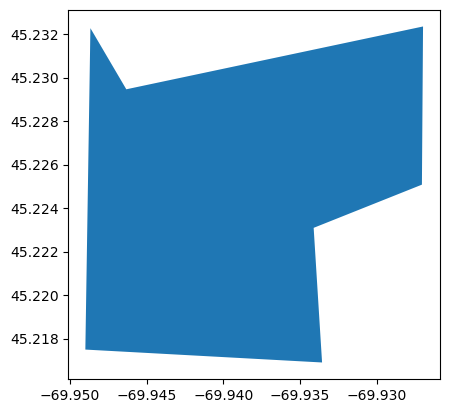

In [11]:
aoi.plot()

# Clip the images to AOI

Create a boolean mask from the aoi to using the shape and transform of the raster dataset.

In [12]:
clipped = dataset.rio.clip(aoi.geometry.apply(mapping), aoi.crs)

In [13]:
print(clipped)

<xarray.Dataset>
Dimensions:      (time: 23, x: 245, y: 170)
Coordinates:
  * time         (time) object 2021-04-09 00:00:00 ... 2021-11-25 00:00:00
  * x            (x) float64 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
  * y            (y) float64 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NIR       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:    Area
    crs:              +init=epsg:4326
    descriptions:     {RED,GREEN,BLUE,NIR}
    res:              [8.98405270e-05 9.04387077e-05]
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    ulx, uly:         [-69.94990454  45.23320715]
    _FillValue:       nan


# Explore the data

check and remove null values

In [14]:
variable_names = clipped['S2_RED'].values
print(variable_names)

[[[   nan    nan    nan ... 0.0372 0.0361 0.0303]
  [   nan    nan    nan ... 0.0584 0.0645 0.0378]
  [   nan    nan    nan ... 0.0402 0.0595 0.037 ]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 [[   nan    nan    nan ... 0.0312 0.0358 0.0326]
  [   nan    nan    nan ... 0.0347 0.0413 0.0314]
  [   nan    nan    nan ... 0.0358 0.0424 0.0318]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 [[   nan    nan    nan ... 0.0242 0.0283 0.0242]
  [   nan    nan    nan ... 0.0257 0.0347 0.0243]
  [   nan    nan    nan ... 0.0288 0.0337 0.0224]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 ...

 [[   nan    nan    nan ... 0.0249 0.0263 0.0228]
  [   nan    nan    

In [15]:
print(clipped.isnull())

<xarray.Dataset>
Dimensions:      (time: 23, y: 170, x: 245)
Coordinates:
  * time         (time) object 2021-04-09 00:00:00 ... 2021-11-25 00:00:00
  * x            (x) float64 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
  * y            (y) float64 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) bool True True True True ... True True True True
    S2_NIR       (time, y, x) bool True True True True ... True True True True


new masked xarray dataset.

In [16]:
data = clipped.where(~dataset.isnull(), drop=True)
print(data)
#non_null_values = data.where(~data.isnull(), drop=True)

<xarray.Dataset>
Dimensions:      (time: 23, y: 170, x: 245)
Coordinates:
  * time         (time) object 2021-04-09 00:00:00 ... 2021-11-25 00:00:00
  * x            (x) float64 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
  * y            (y) float64 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NIR       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:    Area
    crs:              +init=epsg:4326
    descriptions:     {RED,GREEN,BLUE,NIR}
    res:              [8.98405270e-05 9.04387077e-05]
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    ulx, uly:         [-69.94990454  45.23320715]
    _FillValue:       nan


# Compute NDVI

define a function which takes the dataset as input then computes NDVI and creates a new variable in the dataset which stores the NDVI value.

In [17]:
def CalculateNDVI(dataset,redBand,nirBand):
    red=dataset[redBand]
    NIR=dataset[nirBand]
    NDVI = (NIR - red) / (NIR + red)
    
    # create new variable in the dataset
    dataset["S2_NDVI"] = NDVI
    dataset["S2_NDVI"].attrs = {
        "crs": "+init=epsg:4326",
        "descriptions": "Normalized Difference Vegetation Index"
    }
    
    return dataset


Call the function to the dataset by passing the dataset and the red and NIR bands

In [18]:
NDVIdataset = CalculateNDVI(data,"S2_RED","S2_NIR")
print(NDVIdataset)

<xarray.Dataset>
Dimensions:      (time: 23, y: 170, x: 245)
Coordinates:
  * time         (time) object 2021-04-09 00:00:00 ... 2021-11-25 00:00:00
  * x            (x) float64 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
  * y            (y) float64 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NIR       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NDVI      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:    Area
    crs:              +init=epsg:4326
    descriptions:     {RED,GREEN,BLUE,NIR}
    res:              [8.98405270e-05 9.04387077e-05]
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    ulx, uly:         [-69.94990454  45.23320715]
    _FillValue:       nan


# Visualize NDVI,NDVI Histogram and Timeseries

Plot NDVI histogram: The variable however has three dimensions, time, x and y hence the need to  flatten the array to only one dimension using the ravel() method from numpy.

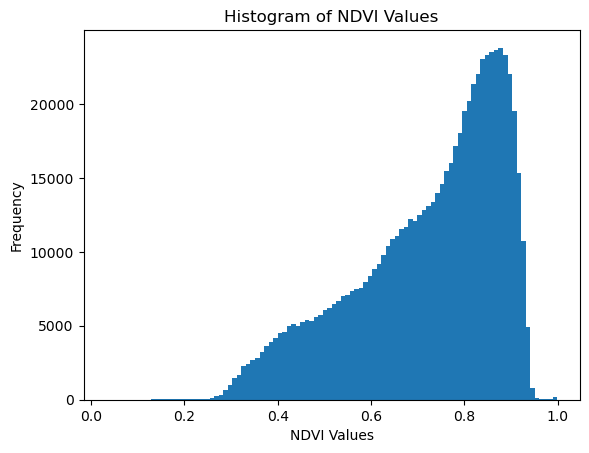

In [19]:
#ndvi values from the dataset
ndvi = data["S2_NDVI"].values.ravel()

# histogram of ndvi values
plt.hist(ndvi, bins=100)

# plot title and axis labels
plt.title("Histogram of NDVI Values")
plt.xlabel("NDVI Values")
plt.ylabel("Frequency")


plt.show()

Timesries

In [20]:
print(NDVIdataset["time"])

<xarray.DataArray 'time' (time: 23)>
array([cftime.DatetimeProlepticGregorian(2021, 4, 9, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 4, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 4, 27, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 5, 7, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 5, 19, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 5, 24, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 5, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 6, 18, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 7, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 8, 10, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2021, 8, 12, 0, 0, 0, 0, has_year_zero=True),
       c

In [21]:
NDVIdataset["time"]=NDVIdataset["time"].astype("datetime64[ns]")
print(NDVIdataset["time"])

<xarray.DataArray 'time' (time: 23)>
array(['2021-04-09T00:00:00.000000000', '2021-04-14T00:00:00.000000000',
       '2021-04-27T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-19T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-29T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-07-28T00:00:00.000000000', '2021-08-10T00:00:00.000000000',
       '2021-08-12T00:00:00.000000000', '2021-08-25T00:00:00.000000000',
       '2021-09-04T00:00:00.000000000', '2021-09-16T00:00:00.000000000',
       '2021-09-19T00:00:00.000000000', '2021-09-21T00:00:00.000000000',
       '2021-10-06T00:00:00.000000000', '2021-10-09T00:00:00.000000000',
       '2021-10-29T00:00:00.000000000', '2021-11-05T00:00:00.000000000',
       '2021-11-20T00:00:00.000000000', '2021-11-23T00:00:00.000000000',
       '2021-11-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
    sp

AvgNDVI['time'] variable contains cftime objects instead of standard datetime objects. Matplotlib's plot function does not support cftime objects directly hence convert the cftime objects to standard datetime objects.

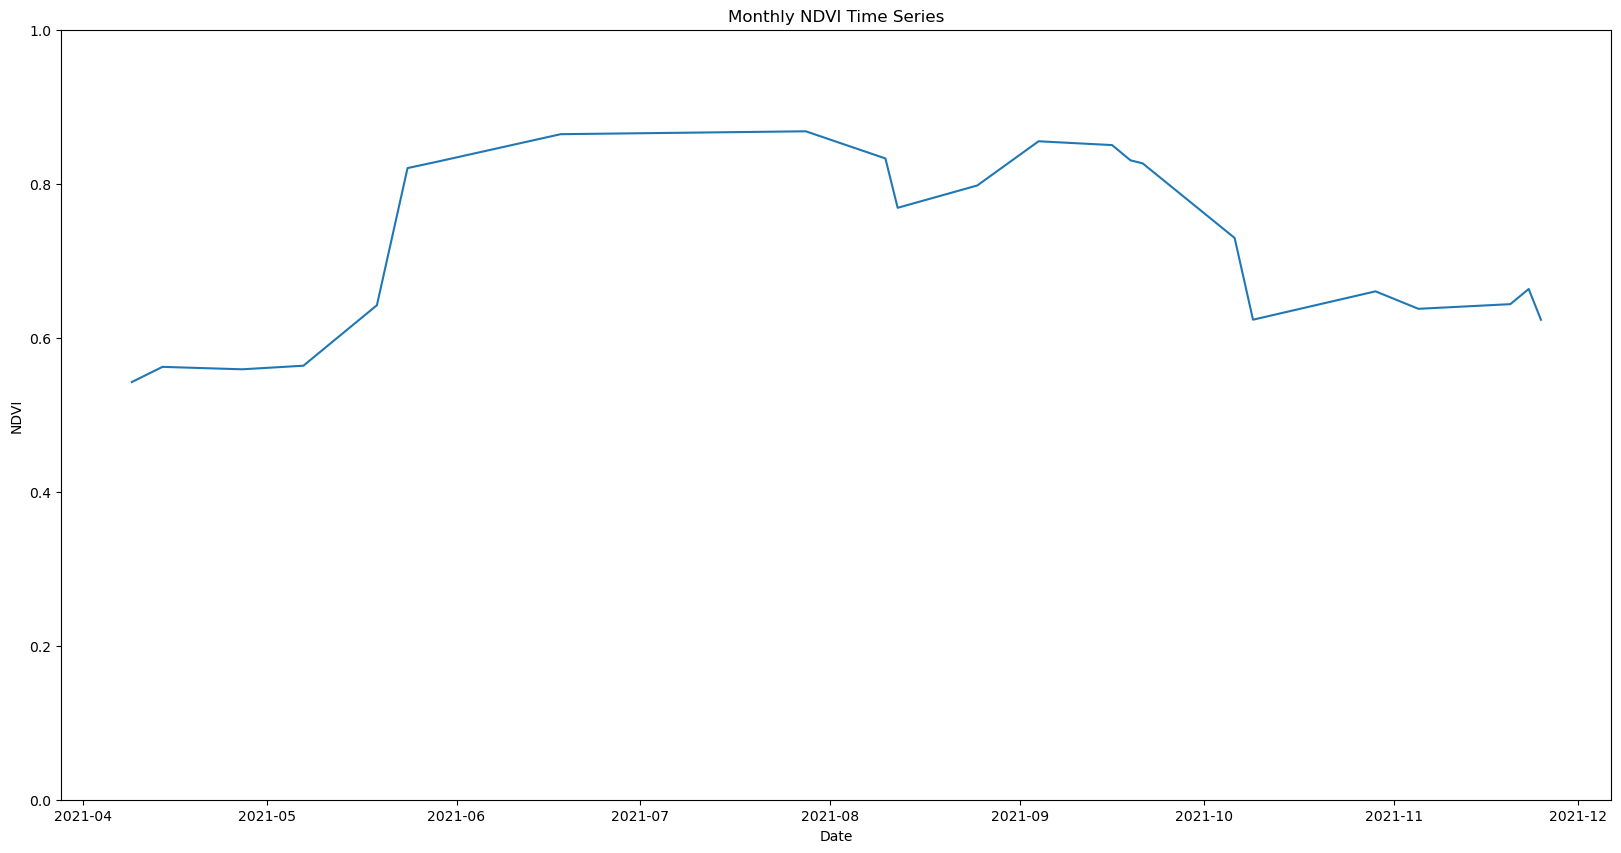

In [22]:


# Compute the mean NDVI value for each time step
AvgNDVI = NDVIdataset['S2_NDVI'].mean(dim=['y', 'x'])
time=NDVIdataset["time"]


plt.figure(figsize=(20,10))

# Plot monthly NDVI as a time series
plt.plot(time, AvgNDVI)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.ylim(0, 1)
# Set title
plt.title('Monthly NDVI Time Series')

# Show plot
plt.show()






From the dataset's corner coordinates  ulx, uly:[-69.94990454  45.23320715], it is noted that the NDVI values observed are from an area in North America which experiences four seasons. Between April and May is characterized by period of growth and rejuvenation of plants as weather gets warmer and as it transitions from Spring to Summer, NDVI values rise drastically.  Generally the summer time is characterized by precipitation, warmer weather and longer daylight hours hence vegetation thrive. However a small decrease is observed(early August) which could be attributed to temperatures being too high hence causing distress to vegetation. However NDVI values then rise again as a result of the transition from Summer to autumn which is characterized by cooler temperatures and high precipitation which rejuvenates the vegetation. As autumn progresses into winter, NDVI values once again drop as vegetation withers.

 visualize all NDVI values as an image with a color map using Matplotlib's imshow() function

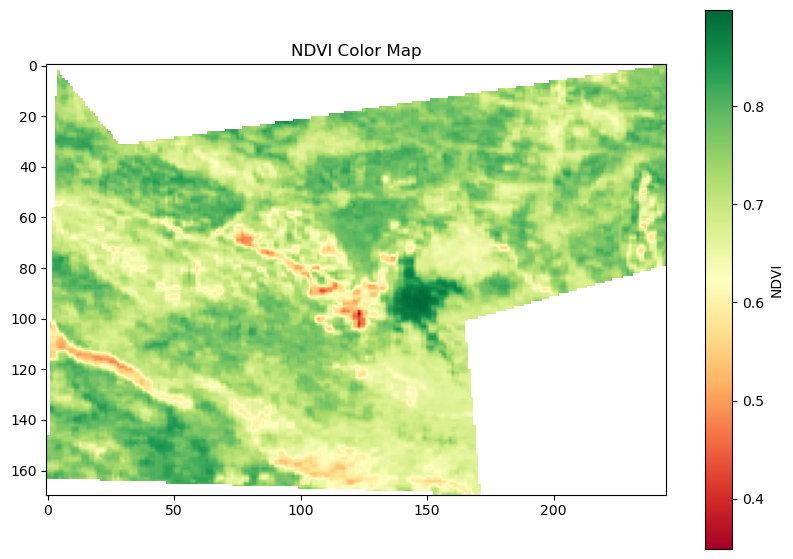

In [23]:
# Select all time steps of NDVI data
ndvi_all = NDVIdataset['S2_NDVI']

# Compute mean NDVI value for each pixel over all time steps
ndvi_mean = ndvi_all.mean(dim='time')



# Plot NDVI as a color map
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(ndvi_mean, cmap='RdYlGn')
ax.set_title('NDVI Color Map')


# Add color bar with label
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.ax.set_ylabel('NDVI', rotation=90)
plt.show()


plt.close()



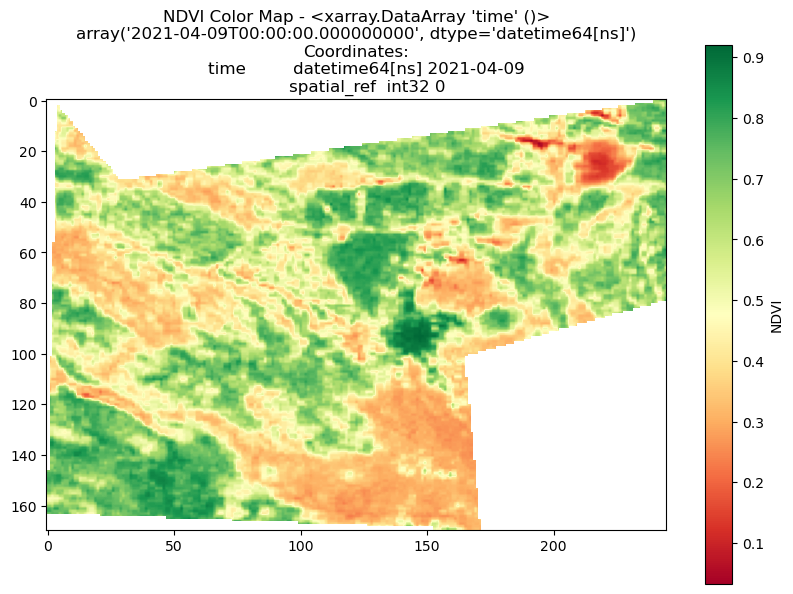

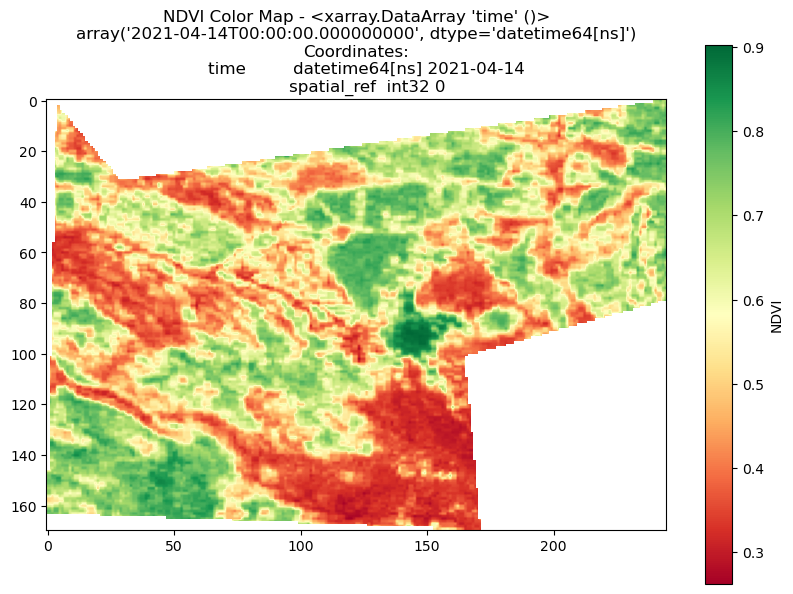

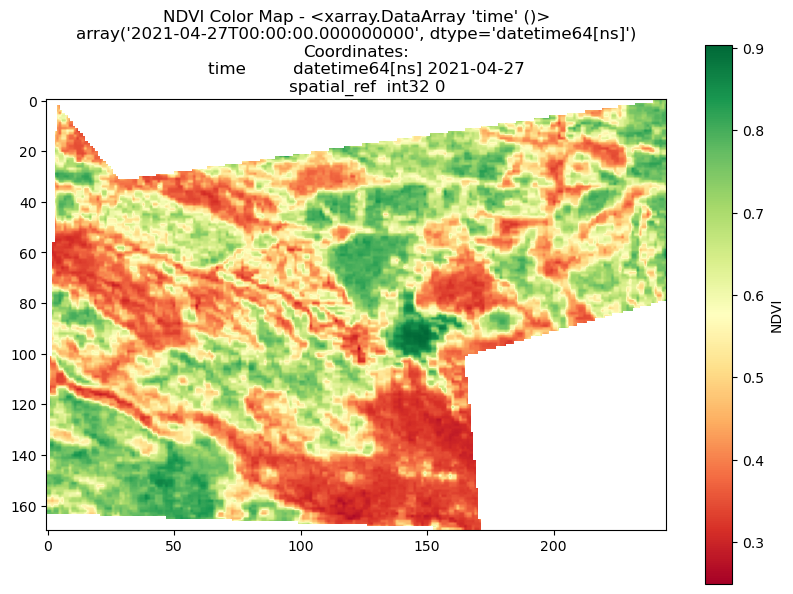

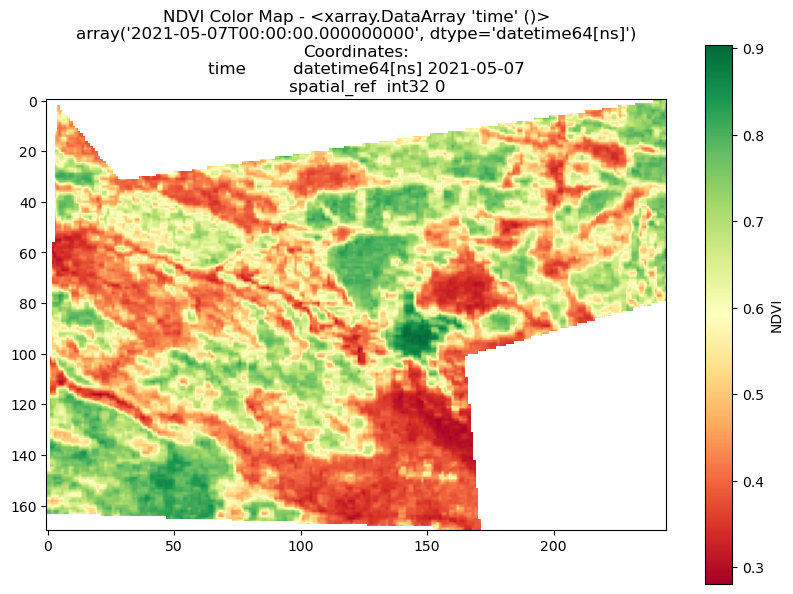

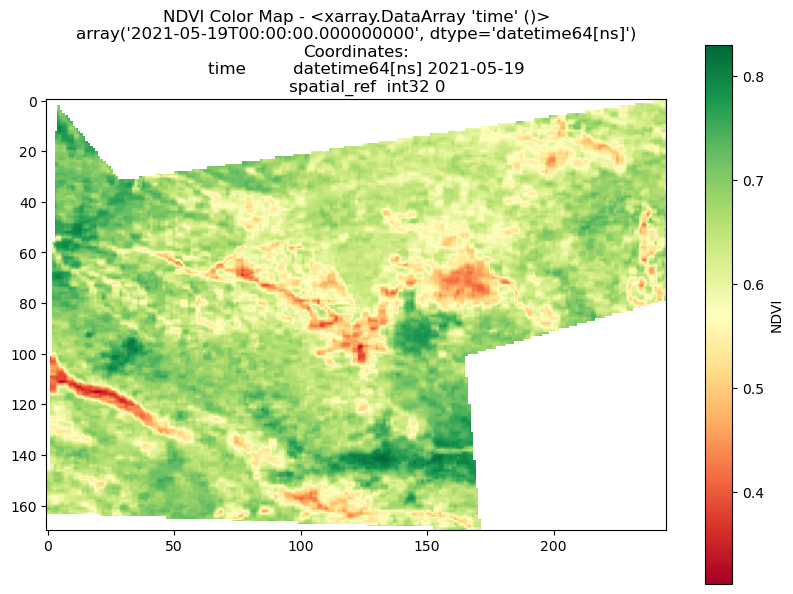

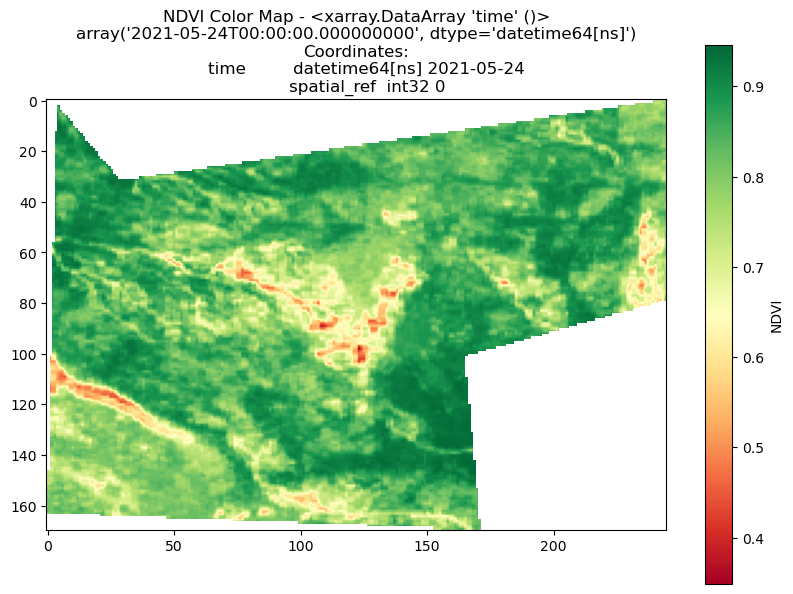

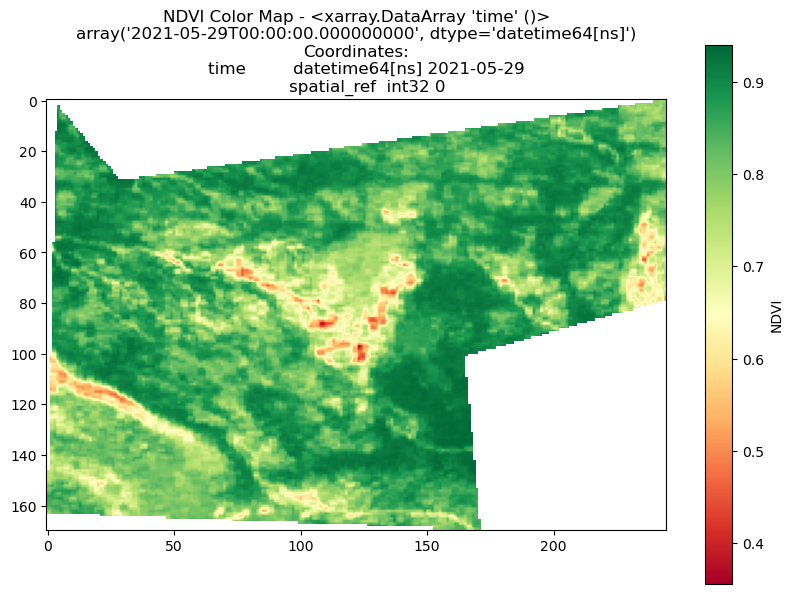

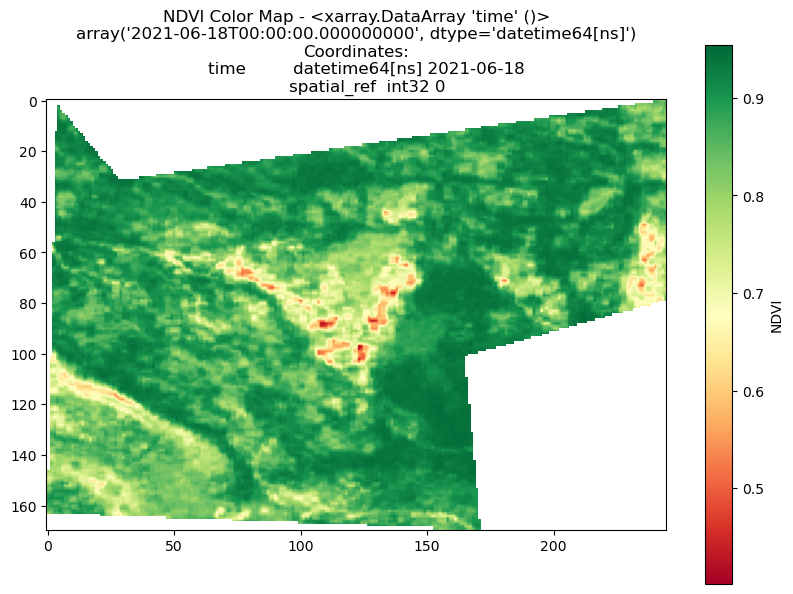

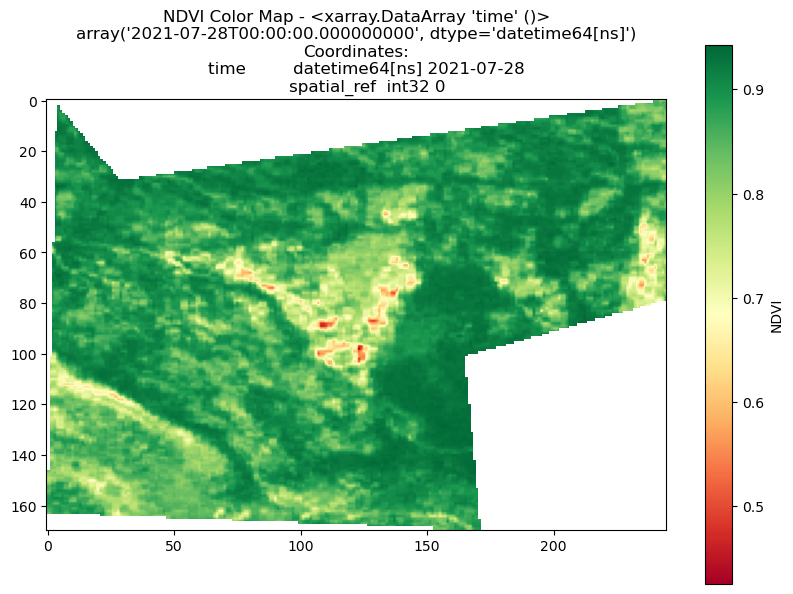

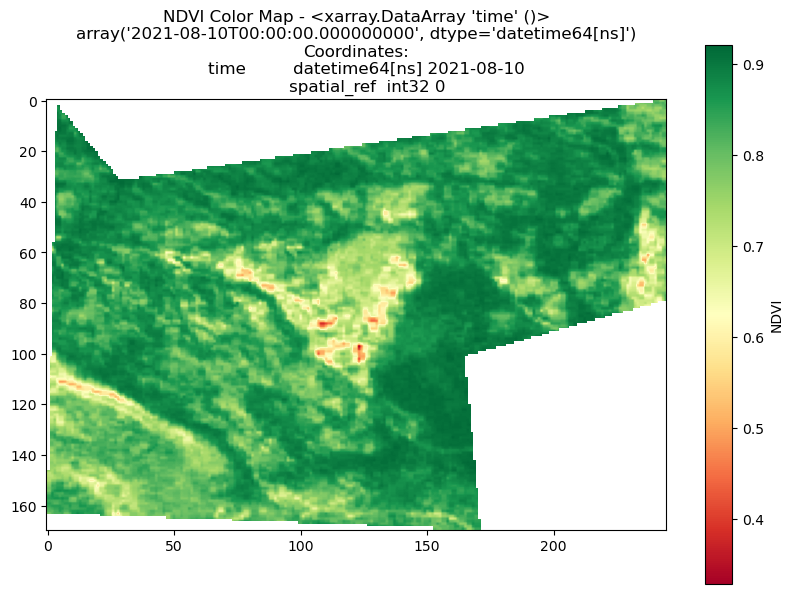

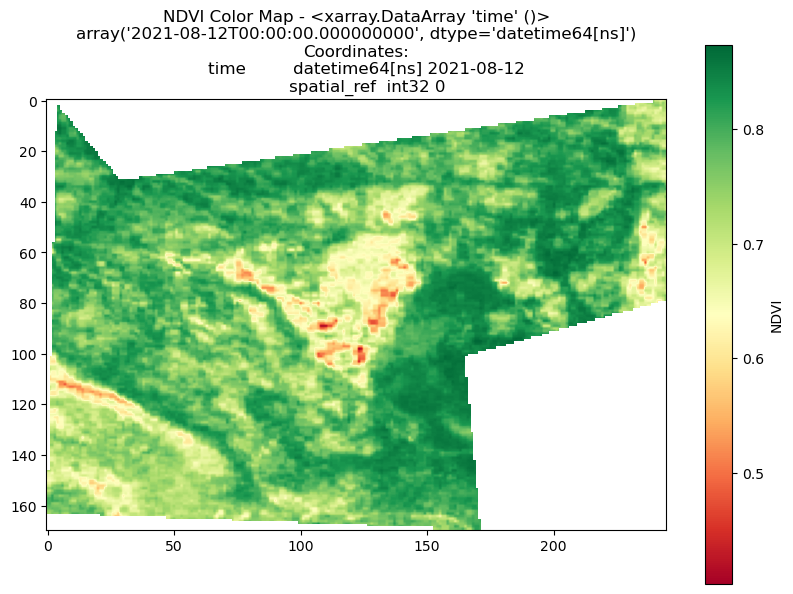

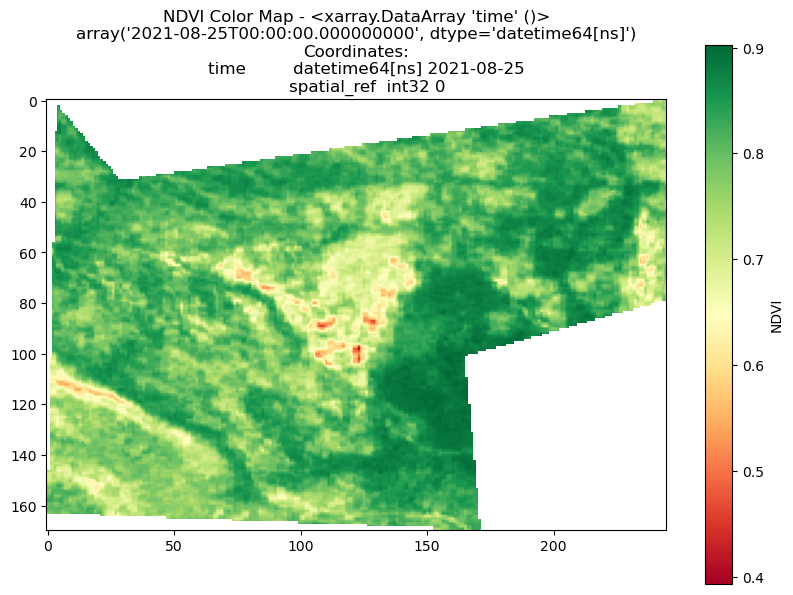

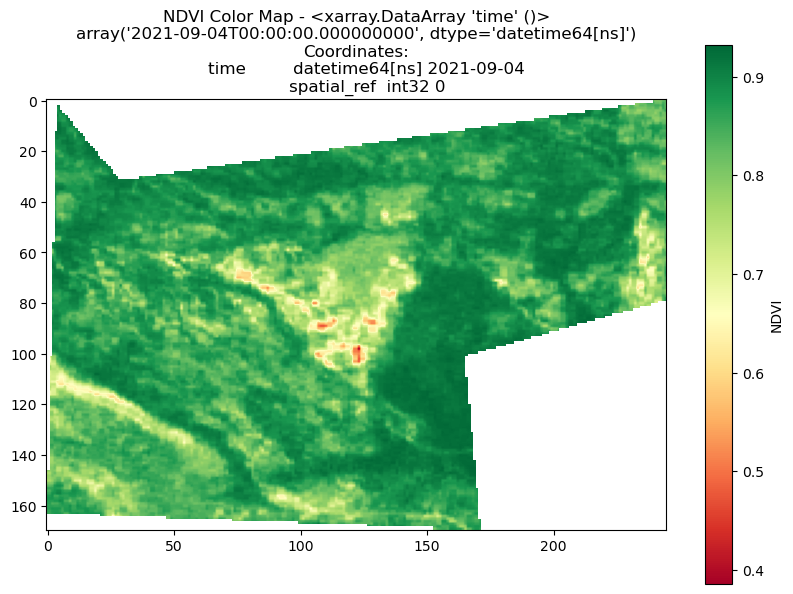

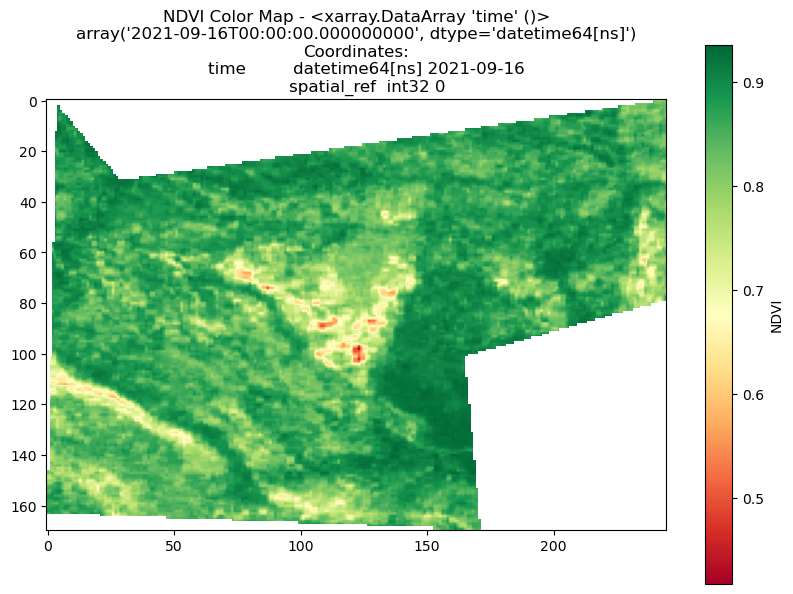

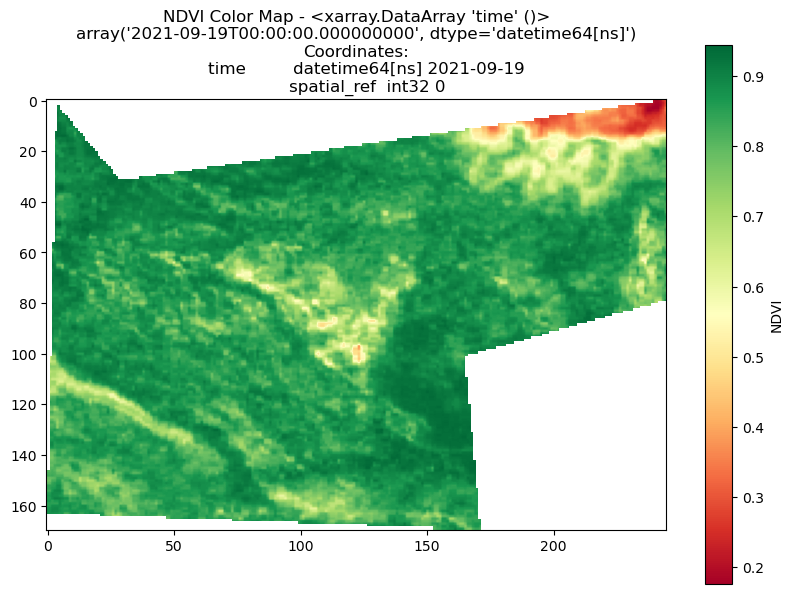

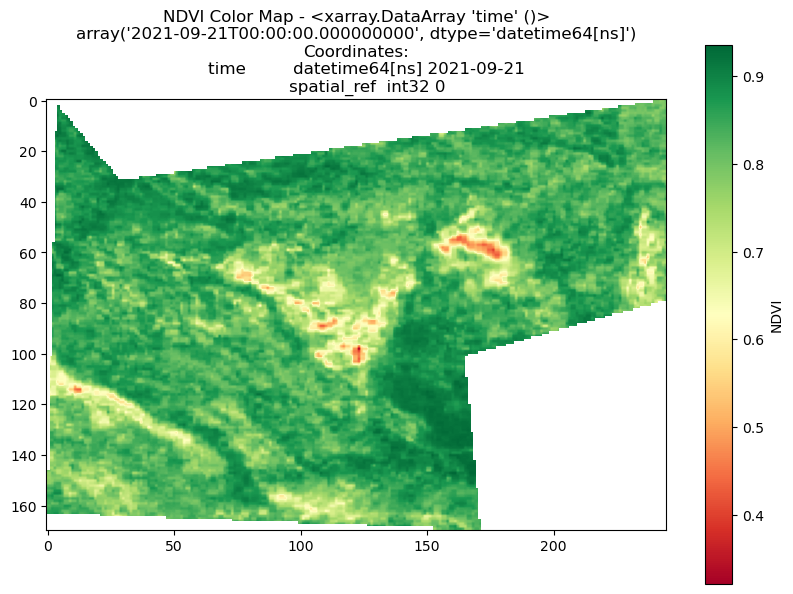

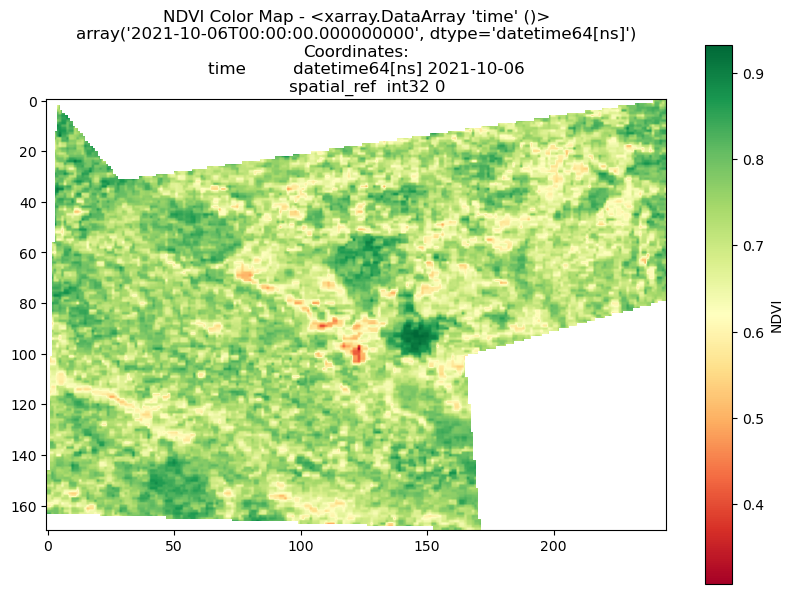

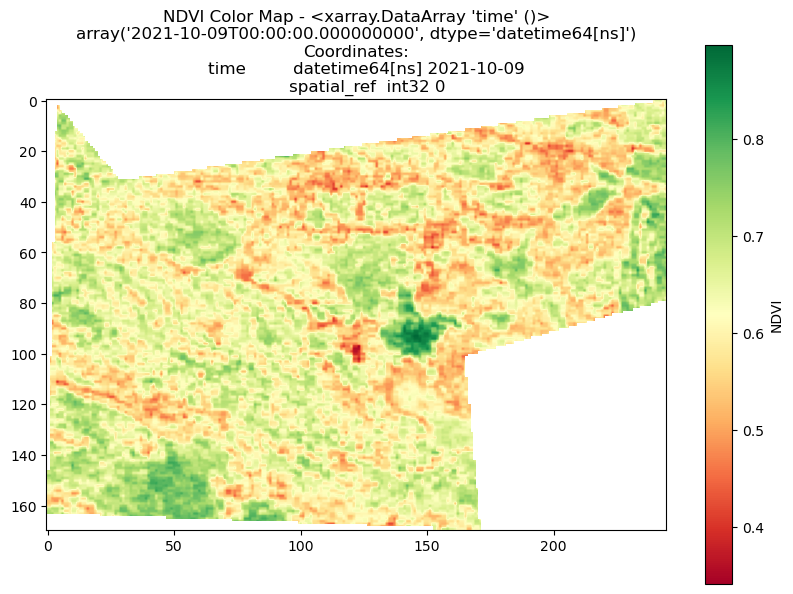

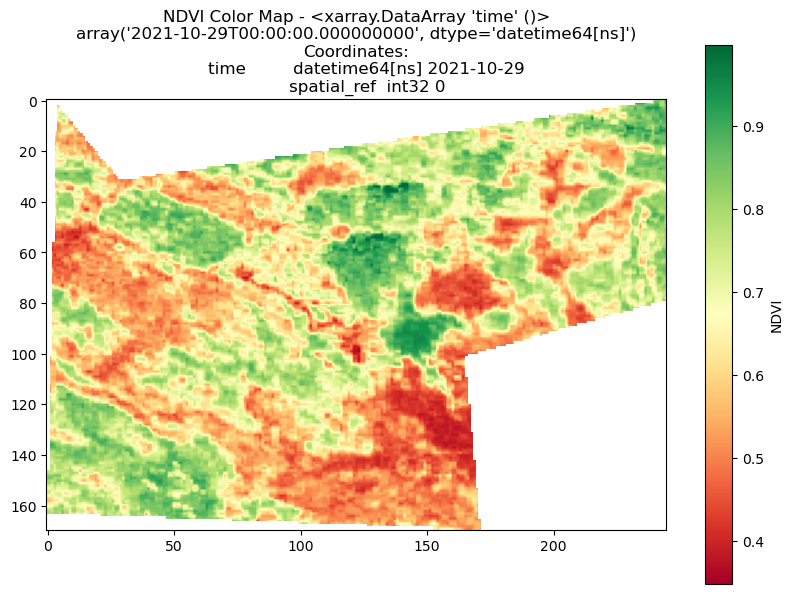

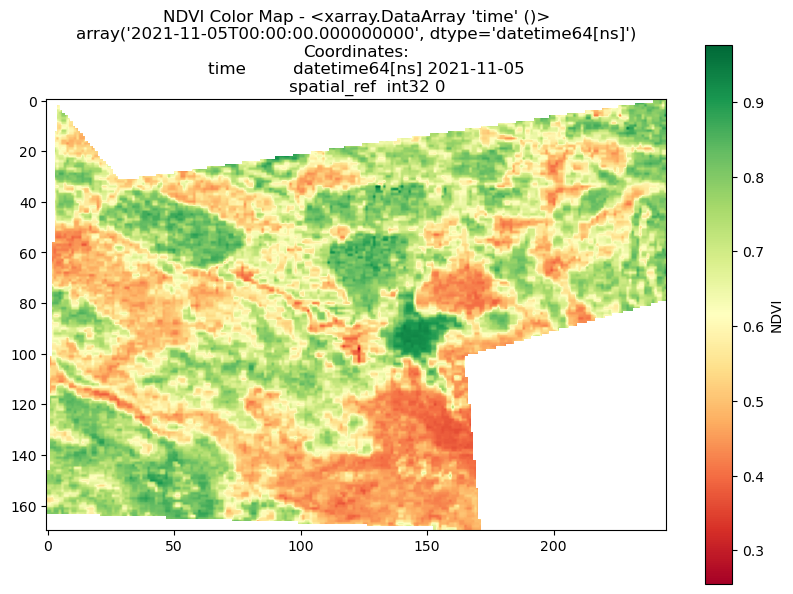

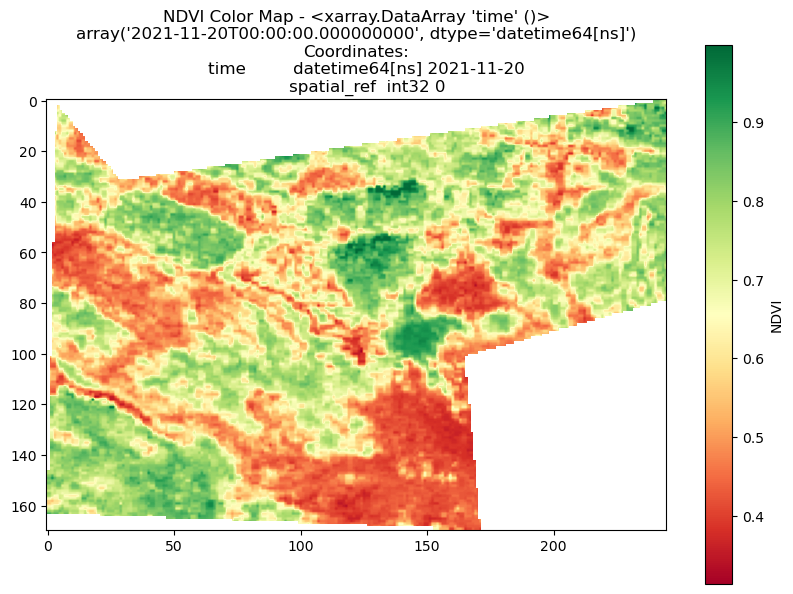

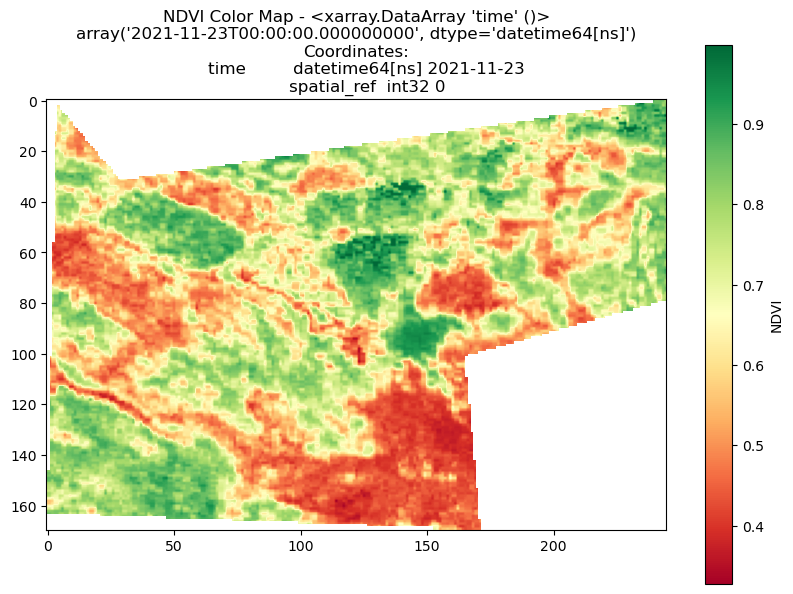

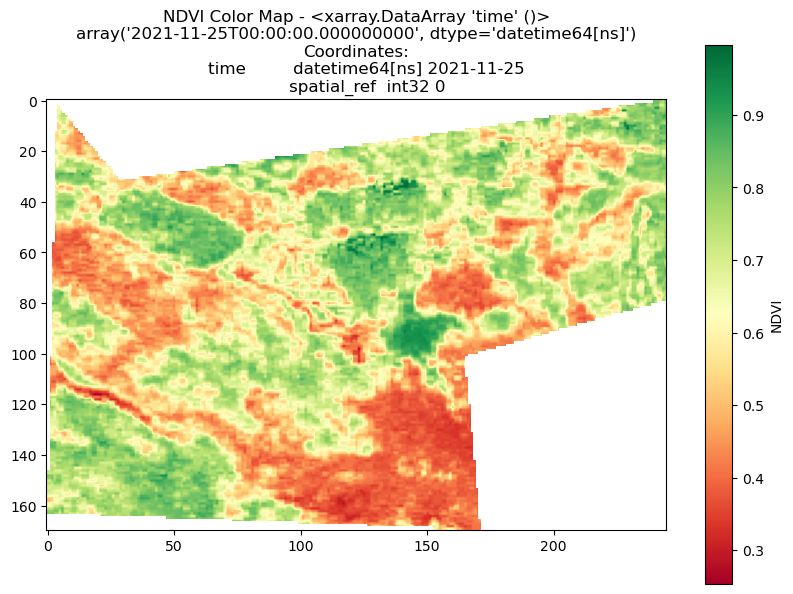

In [24]:
# Select NDVI data 
All_NDVI = NDVIdataset['S2_NDVI']
# Loop over the time steps and create a plot for each month
for i, t in enumerate(ndvi_all['time']):
    # Extract NDVI values for current month
    ndvi_t = ndvi_all.isel(time=i)
    
    # Plot NDVI as a color map
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(ndvi_t, cmap='RdYlGn')
    ax.set_title(f'NDVI Color Map - {t}')
    
    # Add color bar with label
    cbar = fig.colorbar(im, ax=ax, shrink=0.7)
    cbar.ax.set_ylabel('NDVI', rotation=90)
    plt.show()
    
    # Save plot as PNG file to current working folder
    plt.savefig(f'ndvi_plots/ndvi_{i}.png')
    plt.close()


In [25]:
#gif visualization